# **WE 2.2.3: Criteria exploration**

In [1]:
library(tidyverse)
library(here)
library(ggrepel)
library(jsonlite)
library(reticulate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /srv/home/cmyrick/incubator-data-exploration


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




In [2]:
## Run all wrangling notebooks for up-to-date data
#pycmd <- "python -m jupyter nbconvert --ExecutePreprocessor.timeout=None --to notebook --execute 02_wrangling_scripts/wrangle_final.ipynb"
#cat(pycmd)

## Execute command to run another notebook (in this case wrangle_final.ipynb)
## This will update the TSV outputs from that notebook, which will be loaded into this notebook in the cells below
#system(pycmd, intern = TRUE) #### update with names

# Load data

**Run queries**

In [3]:
# Prep to be able to run spark queries using reticulate package
# per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()
use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- import('wmfdata')

In [4]:
# Query page counts data
sql_text <- readLines(here("02_wrangling_scripts/queries/page_count_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfp_import <- wmfdata$spark$run(sql_string)

In [6]:
# Query monthly edits data
sql_text <- readLines(here("02_wrangling_scripts/queries/monthly_edits_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfe_import <- wmfdata$spark$run(sql_string)

**Load TSVs**

In [7]:
# Load list of new language requests that are "Verified for eligibility", per https://meta.wikimedia.org/wiki/Requests_for_new_languages
ver <- read_tsv(here("02_wrangling_scripts/temp_outputs/requests_for_new_languages-verified_and_discussion.tsv"), show_col_types=F) %>%
 filter(req_status=="Verified") %>%
 select(language_code, req_language_name, req_status, project)

In [8]:
# Load project list
projs <- read_tsv(here("03_wrangled_data/projects.tsv"), show_col_types=F) %>%
 select(prefix, language_name, canonical_status, `test-host`, project) %>%
 filter(grepl("test", `test-host`), project!="Wikiversity", project!="Wikisource" ) %>% # filter for only test wikis in Incubator
 mutate(prefix_copy = prefix) %>%
 separate(prefix_copy, into=c("project_abbr", "language_code"), sep="/")

**Wrangle**

In [19]:
# Aggregate edits per project (i.e. combine page_namespaces)
dfe <- dfe_import %>%
 dplyr::group_by(wiki_db, prefix, year, month) %>%
 dplyr::summarise(edits_count = sum(edits_count)) %>%
 dplyr::ungroup()

# Aggregate page counts per project. year, and month (i.e. combine page_namespaces)
dfp <- dfp_import %>%
 dplyr::group_by(snapshot, prefix) %>%
 dplyr::summarise(pages_count = sum(pages_count)) %>%
 dplyr::ungroup()

`summarise()` has grouped output by 'wiki_db', 'prefix', 'year'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'snapshot'. You can override using the
`.groups` argument.


In [20]:
# Join queried data with project list
dfp <- dfp %>% inner_join(., projs, by="prefix")
dfe <- dfe %>% inner_join(., projs, by="prefix")

# Create df: only Wikipedias

In [21]:
wikipedias <- projs %>% filter(project=="Wikipedia")

# Count
xtabs(~project, wikipedias) 

project
Wikipedia 
      738 

In [22]:
## FYI: Why are there 738 test Wikipedias in the projs df, only 737 test Wikipedias in the product data?
## Because "Wp/ak" has no content in Incubator yet, so no data in product data yet
#projs %>% filter(project=="Wikipedia" & grepl("test",`test-host`)) %>% select(prefix) %>% distinct(.) %>%
# anti_join(., df, by="prefix") %>%
# anti_join(., dfe, by="prefix") %>%
# anti_join(., dfp, by="prefix") 

# Create df: only "verified" projects
per https://meta.wikimedia.org/wiki/Requests_for_new_languages

In [23]:
verified <- projs %>% 
 inner_join(., ver, by=c("language_code", "project"))

# Counts
xtabs(~project, ver) 

project
  Wikibooks    Wikinews   Wikipedia   Wikiquote  Wikisource Wikiversity 
         20          49         197          24          34          26 
 Wikivoyage  Wiktionary 
         31          76 

# Create df: at least ___ edits in past 12 months

In [24]:
# Define edit_dt
dfe_filtered <- dfe %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt)) 

# Filter for past year
dfe_filtered <- dfe_filtered %>% 
 filter(edit_dt > "2023-05-01" & edit_dt < "2024-06-01") %>% # <--- HERE: DATE RANGE 
# Prep all 12 past months per project
 select(prefix, edit_dt, edits_count) %>%
 spread(., key="edit_dt", value="edits_count") %>%
# (re)Spread to add NA for any missing month, per project 
 gather(., key="edit_dt", value="edits_count", `2023-06-01`:`2024-05-01`) %>% # <--- HERE: DATE RANGE 
 mutate(edits_count = replace_na(edits_count, 0)) %>%
# Calculate monthy avg
 dplyr::group_by(prefix) %>%
 dplyr::mutate(monthly_edits_avg=mean(edits_count)) %>%
 dplyr::ungroup() %>%
# Calculate sum of edits
 dplyr::group_by(prefix) %>%
 dplyr::mutate(monthly_edits_sum=sum(edits_count)) %>%
 dplyr::ungroup() %>%
# Add monthly dummies 
 dplyr::group_by(prefix) %>%
 dplyr::mutate(monthly_dummy = if_else(edits_count==0, 0, 1)) %>% # 0 dummy = no edit that month, 1 dummy = at least 1 edit that month
 dplyr::ungroup() %>%
 dplyr::group_by(prefix) %>%
# Sum the dummies (min 0 max 12)
 dplyr::mutate(sum_monthly_dummy = sum(monthly_dummy)) %>%
 dplyr::ungroup()

In [25]:
# Keep only projects with at 1 edit per month (past 12 months)
one_edit_per_month <- dfe_filtered %>% 
 filter(sum_monthly_dummy>=12) %>% # <---- 1+ edit per month in past 12 months
# filter(monthly_edits_sum >=1) %>% # <---- 1+ edit/editor in past 12 months
select(prefix, sum_monthly_dummy, edit_dt, edits_count, monthly_edits_avg) %>%
 distinct(.) %>%
 inner_join(., projs, by="prefix") 

# Count update
xtabs(~project,  (one_edit_per_month %>% select(prefix, project) %>% distinct(.)))

project
 Wikibooks   Wikinews  Wikipedia  Wikiquote Wikivoyage Wiktionary 
         2          4         26          5          5          2 

# Create df: fewer than 500 pages

In [26]:
less_500_pages <- projs %>% 
 left_join(., dfp %>% select(prefix, pages_count), by="prefix") %>%
 filter(pages_count<500) 

# Counts
xtabs(~project, (less_500_pages %>% select(prefix, project) %>% distinct(.)))

project
 Wikibooks   Wikinews  Wikipedia  Wikiquote Wikivoyage Wiktionary 
       116        109        670         92        123        239 

# Join and view remaning projects

In [27]:
projs_joined <- projs %>%
 inner_join(., 
            wikipedias %>% 
            select(prefix), 
            by="prefix") %>%
 inner_join(., 
            verified %>% 
            select(prefix, req_status), 
            by="prefix") %>%
 inner_join(., 
            one_edit_per_month %>% 
            select(prefix, edit_dt, edits_count, sum_monthly_dummy, monthly_edits_avg), 
            by="prefix") %>%
 inner_join(., 
            less_500_pages %>% 
            select(prefix, pages_count), 
            by="prefix") %>%
 select(-c(canonical_status))

In [28]:
nrow(projs_joined %>% select(prefix) %>% distinct(.))
projs_joined %>% select(prefix, language_name, project, `test-host`) %>% distinct(.)

[1] 4

prefix language_name   project   test-host
1 Wp/ppl Pipil           Wikipedia test     
2 Wp/izh Ingrian         Wikipedia test     
3 Wp/rsk Pannonian Rusyn Wikipedia test     
4 Wp/ann Obolo           Wikipedia test

## Summary stats

In [29]:
options(repr.plot.width=8.5, repr.plot.height=8.5)

**Pages**

project   project count mean pages median pages
1 Wikipedia 4             323        412.5

Warning message in geom_text(data = projs_joined, aes(0, mean(pages_count), label = (paste0("mean: ", :
“All aesthetics have length 1, but the data has 48 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = projs_joined, aes(0, median(pages_count), label = (paste0("median: ", :
“All aesthetics have length 1, but the data has 48 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


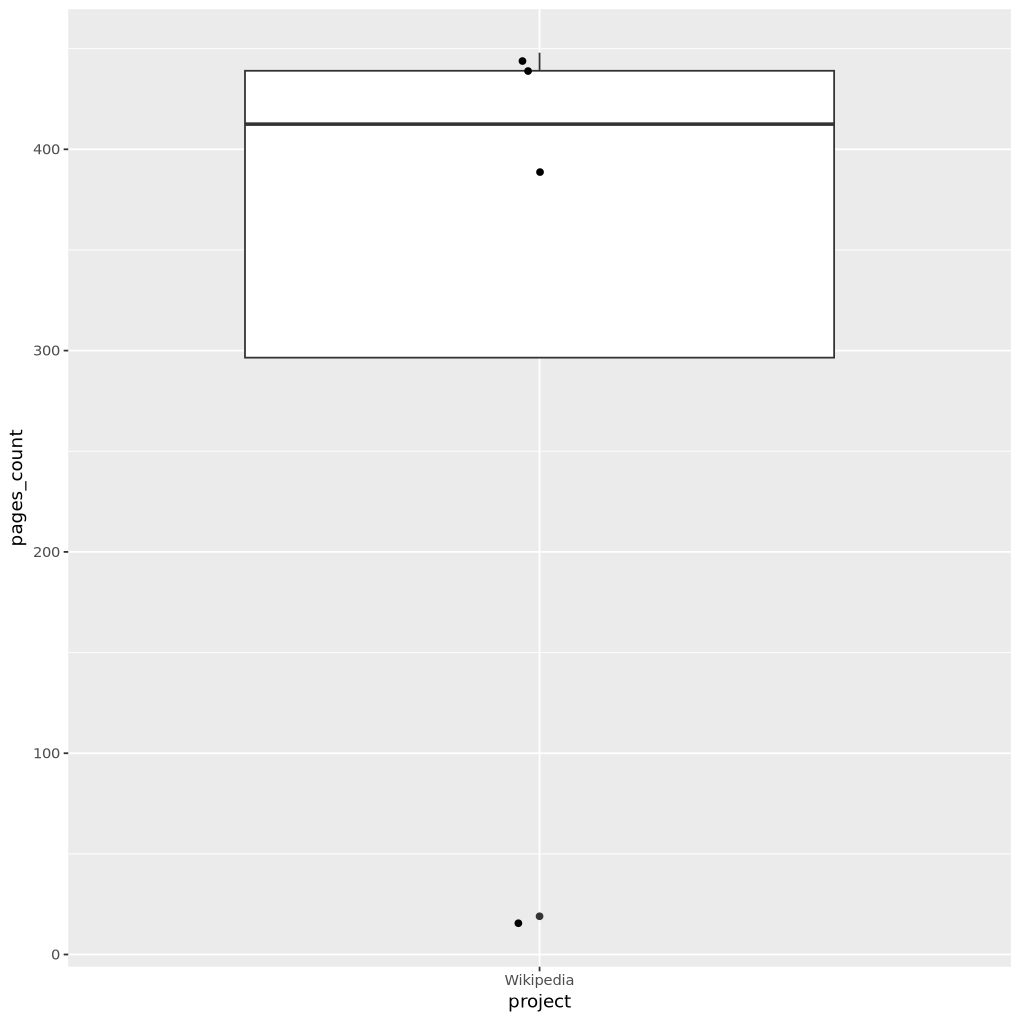

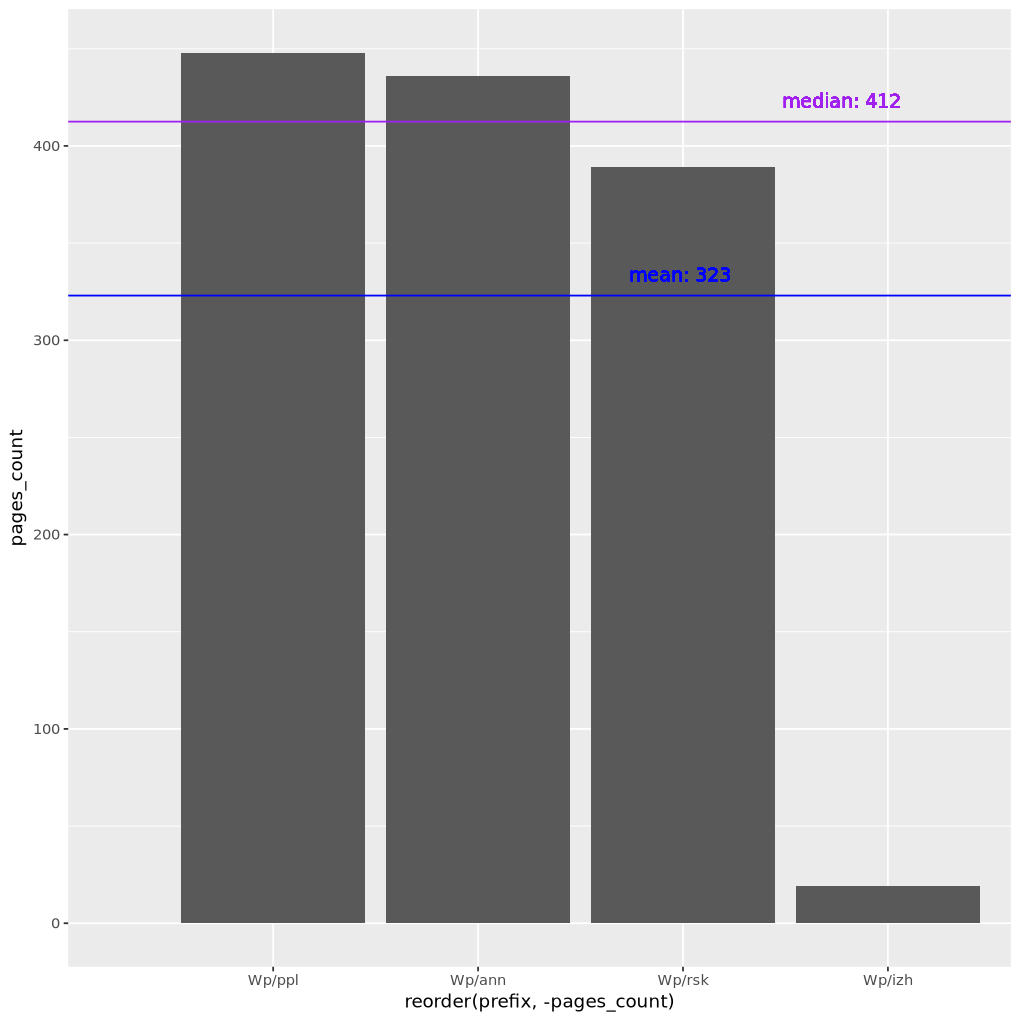

In [30]:
proj_pages <- projs_joined %>% 
 select(project, prefix, pages_count) %>%
 distinct(.) 

# Table: Median and mean pages 
proj_pages %>% 
 select(project, prefix, pages_count) %>%
 distinct(.) %>%
 dplyr::group_by(project) %>% 
 dplyr::summarise(mean=round(mean(pages_count),1)) %>% 
 dplyr::ungroup() %>%
 left_join(., (projs_joined %>% dplyr::group_by(project) %>% 
               dplyr::summarise(median=median(pages_count)) %>% 
               dplyr::ungroup()), by="project") %>%
 left_join(., (projs_joined %>% dplyr::group_by(project) %>% 
               dplyr::summarise(`project count`=nrow(projs_joined %>% 
                                                     select(project, prefix, pages_count) %>%
                                                     distinct(.))) %>% 
               dplyr::ungroup()), by="project") %>%
 dplyr::rename("mean pages" = "mean", "median pages" = "median") %>% 
 select(project, , `project count`, `mean pages`, `median pages`)

# Box plot: pages  
proj_pages %>%
 select(project, prefix, pages_count) %>%
 distinct(.) %>%
 ggplot(aes(x=project, y=pages_count)) +
 geom_boxplot() +
 geom_jitter(width = 0.03)

# Bar plot: pages  
proj_pages %>%
 select(project, prefix, pages_count) %>%
 distinct(.) %>%
 ggplot(aes(x=reorder(prefix,-pages_count), y=pages_count)) +
 geom_bar(stat="identity") +
 geom_line() +
 geom_hline(data=projs_joined, aes(yintercept = mean(pages_count)), color="blue") +
 geom_hline(data=projs_joined, aes(yintercept = median(pages_count)), color="purple") +
 geom_text(data=projs_joined, aes(0,mean(pages_count),
                           label = (paste0("mean: ", round(mean(pages_count),0),sep="")) ,
                            vjust=-1, hjust=-5.5), color="blue", size=4) +
 geom_text(data=projs_joined, aes(0,median(pages_count),
                           label = (paste0("median: ", round(median(pages_count),0),sep="")) ,
                            vjust=-1, hjust=-6), color="purple", size=4) 

**Monthly edits**

project   project count mean pages median pages
1 Wikipedia 48            113.3      121.25

Warning message in geom_text(data = projs_joined, aes(0, mean(monthly_edits_avg), :
“All aesthetics have length 1, but the data has 48 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = projs_joined, aes(0, median(monthly_edits_avg), :
“All aesthetics have length 1, but the data has 48 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


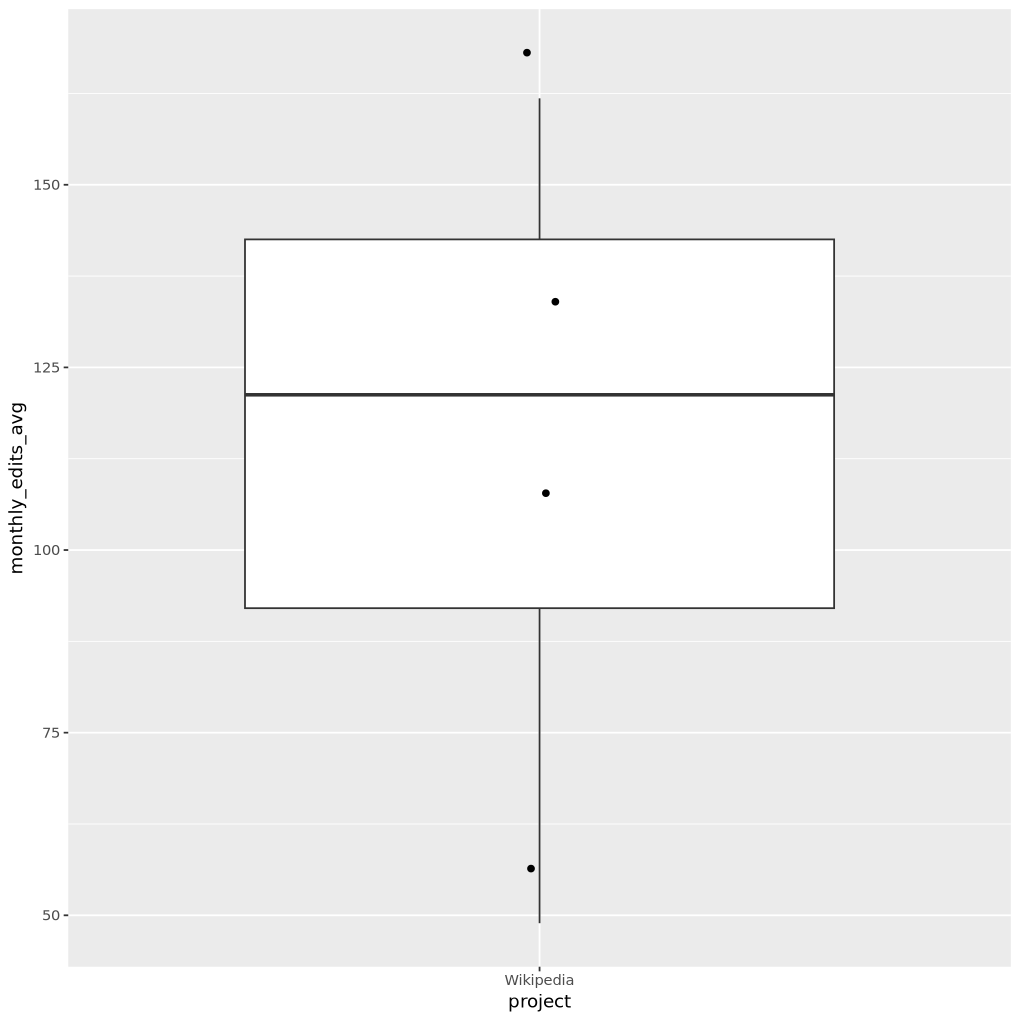

In [31]:
# Table: Median and mean monthly edits (past 12 months)
projs_joined %>%
 select(project, prefix, monthly_edits_avg) %>%
 distinct(.) %>%
 dplyr::group_by(project) %>% 
 dplyr::summarise(mean=round(mean(monthly_edits_avg),1)) %>% 
 dplyr::ungroup() %>%
 left_join(., (projs_joined %>% dplyr::group_by(project) %>% 
               dplyr::summarise(median=median(monthly_edits_avg)) %>% 
               dplyr::ungroup()), by="project") %>%
 left_join(., (projs_joined %>% dplyr::group_by(project) %>% 
               dplyr::summarise(`project count`=nrow(projs_joined)) %>% 
               dplyr::ungroup()), by="project") %>%
 dplyr::rename("mean pages" = "mean", "median pages" = "median") %>% 
 select(project, , `project count`, `mean pages`, `median pages`)

# Box plot: Monthly edits (past 12 months)
projs_joined %>%
 select(project, prefix, monthly_edits_avg) %>%
 distinct(.) %>%
 ggplot(aes(x=project, y=monthly_edits_avg)) +
 geom_boxplot() +
 geom_jitter(width = 0.03)

# Bar plot: Monthly edits (past 12 months)
projs_joined %>%
 select(project, prefix, monthly_edits_avg) %>%
 distinct(.) %>%
 ggplot(aes(x=reorder(prefix,-monthly_edits_avg), y=monthly_edits_avg)) +
 geom_bar(stat="identity") +
 geom_line() +
 geom_hline(data=projs_joined, aes(yintercept = mean(monthly_edits_avg)), color="blue") +
 geom_hline(data=projs_joined, aes(yintercept = median(monthly_edits_avg)), color="purple") +
 geom_text(data=projs_joined, aes(0,mean(monthly_edits_avg),
                           label = (paste0("mean: ", round(mean(monthly_edits_avg),0),sep="")) ,
                            vjust=-1, hjust=-4), color="blue", size=4.5) +
 geom_text(data=projs_joined, aes(0,median(monthly_edits_avg),
                           label = (paste0("median: ", round(median(monthly_edits_avg),0),sep="")) ,
                            vjust=-1, hjust=-4), color="purple", size=4.5) 

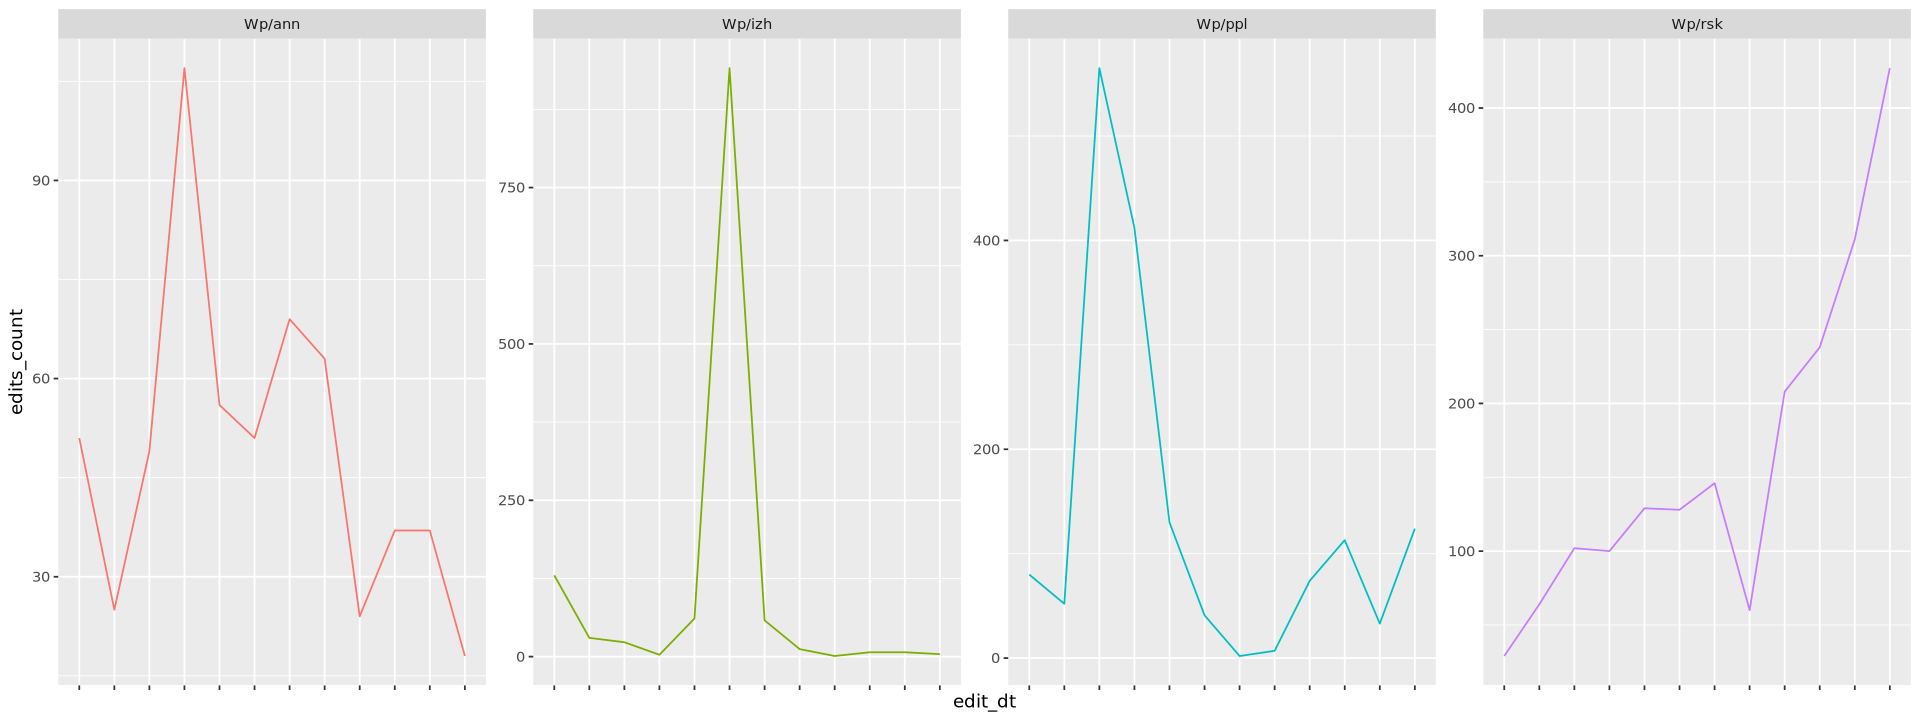

In [32]:
# Line chart: monthly edits
options(repr.plot.width=16, repr.plot.height=6)
projs_joined %>%
 ggplot(aes(x=edit_dt, y=edits_count, group=prefix, color=prefix)) +
 geom_line() +
 theme(legend.position="none", axis.text.x=element_blank()) +
 facet_wrap(.~prefix, ncol=12, scales="free")